3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
Simulated Created
b'ERROR: In CONNECTIONS matrix (switch 0): Flow rate balance is not closed for unit operation 9, imbalanced by 3.167100e-03\r\n'
Simulation Run


TypeError: 'Dict' object is not callable

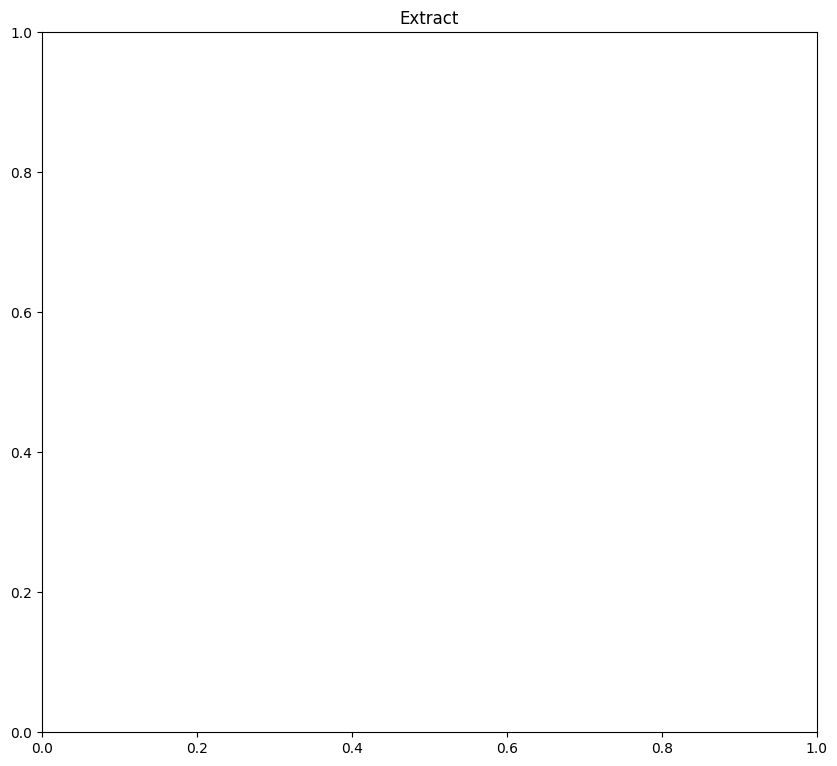

In [9]:
#Basic 4-zone SMB setup
import numpy as np
import math
from cadet import Cadet
#Cadet.cadet_path = "C:/Users/kosh_000/cadet_build/CADET-dev/MS_SMKL_RELEASE/bin/cadet-cli.exe"
Cadet.cadet_path = r"C:\ProgramData\Anaconda3\envs\1cadet\bin\cadet-cli.exe"
#use to render results
import matplotlib.pyplot as plt
#number of columns in a cycle
cycle_size = 24
#number of cycles
cycles = 4
#number of times flows have to be expanded for a 4-zone model
n_comp = 5
repeat_size = int(cycle_size/4)
def gen_connections(units, cycle_size, size, step, flows, flows_static):
    temp = []
    connections = list(zip(units, np.roll(units,-1), flows))
    io = np.roll(units, step)[[0, size*2, size-1, size*3-1]]
    ios = list(zip([0, 1, 2, 3], io))
    for connection in connections:
        temp.append([connection[0], connection[1], -1, -1, connection[2]])
    #inputs
    idx = 0
    for io in ios[:2]:
        temp.append([io[0], io[1], -1, -1, flows_static[idx]])
        idx+=1;
    #outputs
    for io in ios[2:]:
        temp.append([io[1], io[0], -1, -1, flows_static[idx]])
        idx+=1;
    return np.array(temp)
def expand_flow(seq, inlet1, inlet2, number):
    "expand the flows for smb, this is more complex since we need link values"
    temp = []
    temp.extend([seq[3] + inlet1] * (number-1))
    temp.append(seq[0])

    temp.extend([seq[0]] * (number-1))
    temp.append(seq[1])

    temp.extend([seq[1] + inlet2] * (number-1))
    temp.append(seq[2])

    temp.extend([seq[2]] * (number-1))
    temp.append(seq[3])

    return temp

def main():
    smb = Cadet()
    smb.filename  = '2xylene.h5'
    createSimulation(smb)
    print("Simulated Created")
    smb.save()
    smb.run()
    info = smb.run()
    #if info.returncode != 0:
    print(info.stderr)
        #raise Exception("Simulation failed.")
    smb.load()
    print("Simulation Run")
    plotSimulation(smb)
    input = {'Time Input': smb.root.output.solution.solution_times,
             'Concentration Input' : smb.root.output.solution.unit_002.solution_inlet_comp_000,
             'Time Output': smb.root.output.solution.solution_times, 
             'Concentration Output': smb.root.output.solution.unit_002.solution_outlet_comp_000,
             'Time Volume': smb.root.output.solution.solution_times,
             'Volume' : np.squeeze(smb.root.output.solution.unit_001.solution_volume)}
    
    data = pandas.DataFrame(input, columns = ['Time Input','Concentration Input','Time Output',
                                        'Concentration Output', 'Time Volume', 
                                        'Time Volume', 'Volume'])
    
    data.to_excel(r'D:\cadet123\1xylene.xlsx', index = False, header = True)

def createSimulation(simulation):
    simulation.root.input.model.nunits = 4 + cycle_size

    simulation.root.input.model.solver.gs_type = 1
    simulation.root.input.model.solver.max_krylov = 0
    simulation.root.input.model.solver.max_restarts = 0
    simulation.root.input.model.solver.schur_safety = 1e-8


    #setup connections
    simulation.root.input.model.connections.nswitches = cycle_size

    units = range(4, 4+cycle_size)

    flows = expand_flow([0.1103339, 0.1345006, 0.0896672, 0.0928343], 0.0481667, 0.0241667, repeat_size)
    flows_static = np.array([0.0481667,0.0241667, 0.0275, 0.0448334])

    for i in range(cycle_size):
        simulation.root.input.model.connections["switch_%03d" % i].section = i
        simulation.root.input.model.connections["switch_%03d" % i].connections = gen_connections(units, cycle_size, repeat_size, -i, np.array(list(np.roll(flows, i))), flows_static )

    #setup inlets
    simulation.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
    simulation.root.input.model.unit_000.ncomp = n_comp
    simulation.root.input.model.unit_000.unit_type = 'INLET'

    #for i in range(cycle_size):
        #section
    simulation.root.input.model.unit_000.const_coeff = [99.94, 354.7869, 90.659, 0.0, 168.470]
    simulation.root.input.model.unit_001.const_coeff = [0.0,0.0,0.0,722.87,0.0]
        #simulation.root.input.model.unit_000["sec_%03d" % i].quad_coeff = [0.0, 0.0]
        #simulation.root.input.model.unit_000["sec_%03d" % i].cube_coeff = [0.0, 0.0]

    simulation.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'
    simulation.root.input.model.unit_001.ncomp = n_comp
    simulation.root.input.model.unit_001.unit_type = 'INLET'

    #for i in range(cycle_size):
        #section
        #simulation.root.input.model.unit_001["sec_%03d" % i].const_coeff = [0.0, 0.0]
        #simulation.root.input.model.unit_001["sec_%03d" % i].lin_coeff = [0.0, 0.0]
        #simulation.root.input.model.unit_001["sec_%03d" % i].quad_coeff = [0.0, 0.0]
        #simulation.root.input.model.unit_001["sec_%03d" % i].cube_coeff = [0.0, 0.0]

    #create columns
    for unit in range(4, 4 + cycle_size):

        simulation.root.input.model["unit_%03d" % unit].unit_type = 'GENERAL_RATE_MODEL'

        col = simulation.root.input.model["unit_%03d" % unit]

        col.ncomp = n_comp
        col.cross_section_area = math.pi * (4.117**2)/4.0
        col.col_dispersion = 3.8148e-20
        col.col_length = 1.135
        col.col_porosity = 0.83
        col.init_c = [0.0,0.0,0.0,0.0,0.0]
        col.init_q = [0.0,0.0,0.0,0.0,0.0]
        col.film_diffusion = [100.0, 100.0,100.0,100.0,100.0]
        col.par_diffusion = [1.6e4, 1.6e4,1.6e4, 1.6e4,1.6e4]
        col.par_radius = 0.00046
        col.par_porosity = 0.39
        #col.par_surfdiffusion = [0.0, 0.0]
        col.adsorption_model = 'LINEAR'
        col.velocity = 1.0

        col.adsorption.is_kinetic = 0
        col.adsorption.lin_ka = [0.1303,0.1303,0.1303,0.1077,0.1303]
        col.adsorption.lin_kd = [0.3067,0.2299,0.1884,1.2935,1.0658]

        col.discretization.gs_type = 1
        col.discretization.max_krylov = 0
        col.discretization.max_restarts = 0
        col.discretization.nbound = [1,1,1,1,1]
        col.discretization.ncol = 40
        col.discretization.npar = 1
        col.discretization.par_disc_type = 'EQUIDISTANT_PAR'
        col.discretization.par_disc_vector = [0.0, 0.5, 1.0]
        col.discretization.reconstruction = 'WENO'
        col.discretization.schur_safety = 1e-8
        col.discretization.use_analytic_jacobian = 1

        col.discretization.weno.boundary_model = 0
        col.discretization.weno.weno_eps = 1e-12
        col.discretization.weno.weno_order = 3

    #create outlets
    simulation.root.input.model.unit_002.ncomp = n_comp
    simulation.root.input.model.unit_002.unit_type = 'OUTLET'

    simulation.root.input.model.unit_003.ncomp = n_comp
    simulation.root.input.model.unit_003.unit_type = 'OUTLET'

    #create output information

    simulation.root.input['return'].write_solution_times = 1

    ret = simulation.root.input['return']

    ret.write_solution_last = 1

    ret.unit_002.write_sens_column = 0
    ret.unit_002.write_sens_column_inlet = 0
    ret.unit_002.write_sens_column_outlet = 0
    ret.unit_002.write_sens_flux = 0
    ret.unit_002.write_sens_particle = 0

    ret.unit_002.write_solution_column = 0
    ret.unit_002.write_solution_column_inlet = 1
    ret.unit_002.write_solution_column_outlet = 1
    ret.unit_002.write_solution_flux = 0
    ret.unit_002.write_solution_particle = 0

    ret.unit_003.write_sens_column = 0
    ret.unit_003.write_sens_column_inlet = 0
    ret.unit_003.write_sens_column_outlet = 0
    ret.unit_003.write_sens_flux = 0
    ret.unit_003.write_sens_particle = 0

    ret.unit_003.write_solution_column = 0
    ret.unit_003.write_solution_column_inlet = 1
    ret.unit_003.write_solution_column_outlet = 1
    ret.unit_003.write_solution_flux = 0
    ret.unit_003.write_solution_particle = 0
    
    simulation.root.input.solver.nthreads = 0
    simulation.root.input.solver.user_solution_times = np.linspace(0, cycles*69.6*4, 1000*cycle_size*cycles)
    simulation.root.input.solver.sections.nsec = cycle_size*cycles
    simulation.root.input.solver.sections.section_continuity = [0] * (cycle_size*cycles -1)
    simulation.root.input.solver.sections.section_times = [float(i) * 69.6*4.0/cycle_size for i in range(cycle_size*cycles+1)]

    simulation.root.input.solver.time_integrator.abstol = 1e-10
    simulation.root.input.solver.time_integrator.algtol = 1e-10
    simulation.root.input.solver.time_integrator.init_step_size = 1e-14
    simulation.root.input.solver.time_integrator.max_steps = 1e6
    simulation.root.input.solver.time_integrator.reltol = 1e-6


def plotSimulation(simulation):
    solution_times = simulation.root.output.solution.solution_times

    e_0 = simulation.root.output.solution.unit_002.solution_outlet_comp_000
    e_1 = simulation.root.output.solution.unit_002.solution_outlet_comp_001
    e_2 = simulation.root.output.solution.unit_002.solution_outlet_comp_002
    e_3 = simulation.root.output.solution.unit_002.solution_outlet_comp_003
    e_4 = simulation.root.output.solution.unit_002.solution_outlet_comp_004

    r_0 = simulation.root.output.solution.unit_003.solution_outlet_comp_000
    r_1 = simulation.root.output.solution.unit_003.solution_outlet_comp_001
    r_2 = simulation.root.output.solution.unit_003.solution_outlet_comp_002
    r_3 = simulation.root.output.solution.unit_003.solution_outlet_comp_003
    r_4 = simulation.root.output.solution.unit_003.solution_outlet_comp_004

    fig = plt.figure(figsize=[10, 2*10])

    graph = fig.add_subplot(2, 1, 1)
    graph.set_title("Extract")

    graph.plot(solution_times, e_0, 'r', label='EB')
    graph.plot(solution_times, e_1, 'g', label='MX')
    graph.plot(solution_times, e_2, 'blue', label='OX')
    graph.plot(solution_times, e_3, 'black', label='PDEB')
    graph.plot(solution_times, e_4, 'pink', label='PX')
    graph.legend()
        
    graph = fig.add_subplot(2, 1, 2)
    graph.set_title("Raffinate")

    graph.plot(solution_times, r_0, 'r', label='EB')
    graph.plot(solution_times, r_1, 'g', label='MX')
    graph.plot(solution_times, r_2, 'blue', label='OX')
    graph.plot(solution_times, r_3, 'black', label='PDEB')
    graph.plot(solution_times, r_4, 'pink', label='PX')
    graph.legend()
    plt.show()


if __name__ == "__main__":
    import sys
    print(sys.version)
    main()